# **New Approach B: End-to-End LoRA + TTA Fine-Tuning with Multi-Task Learning**
## **Objective**
This notebook implements "New Approach B". Instead of training a simple classifier on frozen embeddings (which limits accuracy), we will **fine-tune the DINOv2 backbone**.

**Why use LoRA (Low-Rank Adaptation)?**
Fine-tuning a 142M parameter model like DINOv2 requires massive GPU memory. LoRA allows us to freeze the main model and only train tiny "adapter" layers (~1% of parameters), making this possible on Google Colab while achieving state-of-the-art results.

**Methodology:**
1.  **Input:** Uses the `aligned_train_metadata.pkl` created in the Data Aligner notebook.
2.  **Multi-Task Learning:** The model simultaneously predicts **Species**, **Leaf Shape**, and **Leaf Arrangement** to force it to learn botanical features.
3.  **Evaluation:** Uses **TenCrop Test-Time Augmentation (TTA)** for robust prediction.

# **1.0 Environment Setup**
We install the specific libraries required for advanced fine-tuning:
*   `peft`: Hugging Face's library for Parameter-Efficient Fine-Tuning (LoRA).
*   `timm`: To load the specific DINOv2 architecture.
*   `kagglehub`: To download the pre-trained weights.

## **1.1 Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive mounted successfully.")

Mounted at /content/drive
✅ Google Drive mounted successfully.


## **1.2 Install Required Libraries**

In [ ]:
# Install Hugging Face transformers for DINOv2 and other utilities.
# The '-q' flag makes the installation output less verbose.
# We include 'timm' as it's required to build the custom juliostat DINOv2 model.
# We add 'peft' for LoRA and 'transformers'.
!pip install pandas scikit-learn torch torchvision tqdm matplotlib timm kagglehub peft transformers -q

print("✅ Required libraries are installed.")

✅ Required libraries are installed.


## **1.3 Import All Libraries**

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# PyTorch and related libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Scikit-learn for metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, top_k_accuracy_score

# Timm, PEFT, and Kaggle Hub for the model
import timm
from peft import get_peft_model, LoraConfig
import kagglehub

## **1.4 Define Project Constants and Paths**

In [ ]:
import os
import torch

# --- Configuration ---
PROJECT_PATH = '/content/drive/My Drive/Colab Notebooks/COS30082_ML_Project'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data files
METADATA_FILE = os.path.join(PROJECT_PATH, 'full_visual_metadata.csv')
EMBEDDINGS_DIR = os.path.join(PROJECT_PATH, 'temp_hgb_features')
DATA_DIR = os.path.join(PROJECT_PATH, 'AML_dataset')
ALIGNED_METADATA_PATH = os.path.join(PROJECT_PATH, 'aligned_train_metadata.pkl') # From the data aligner

# Kaggle cache setup
cache_dir = os.path.join(PROJECT_PATH, 'kaggle_cache')
os.makedirs(cache_dir, exist_ok=True)
os.environ['KAGGLE_CACHE'] = cache_dir

print(f"Project Path: {PROJECT_PATH}")
print(f"Using device: {DEVICE}")
print(f"Kaggle cache path set to: {cache_dir}")

Project Path: /content/drive/My Drive/Colab Notebooks/COS30082_ML_Project
Using device: cuda
Kaggle cache path set to: /content/drive/My Drive/Colab Notebooks/COS30082_ML_Project/kaggle_cache


# **2.0 Data Loading and Preparation (for LoRA)**
We load the aligned metadata. Note that we define **two different transformations**:
1.  **`train_transform`**: Heavy augmentation (Random Crop, Flip, Rotation, Color Jitter). This prevents overfitting and helps the model handle the domain shift from Herbarium to Field.
2.  **`val_transform`**: Deterministic resizing. Used for validation to get consistent metrics.

## **2.1 Load Metadata**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

# --- Step 2.1: Load Metadata ---
print(f"Loading UNORDERED metadata from: {METADATA_FILE}")
df_unordered = pd.read_csv(METADATA_FILE)
print("✅ Unordered metadata (for full class map) loaded successfully.")

# Load the aligned training metadata to get the correct list of training files.
df = pd.read_pickle(ALIGNED_METADATA_PATH)
print("✅ Aligned training metadata loaded successfully.")

Loading UNORDERED metadata from: /content/drive/My Drive/Colab Notebooks/COS30082_ML_Project/full_visual_metadata.csv
✅ Unordered metadata (for full class map) loaded successfully.
✅ Aligned training metadata loaded successfully.


## **2.2: Define Image Transformations**

In [ ]:
import torchvision.transforms as transforms

# Normalization constants (ImageNet defaults)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# 1. Training Transform (With Augmentation)
# - RandomResizedCrop: Forces model to look at local details and global shape
# - Flips/Rotations: Plants can appear in any orientation
# - ColorJitter: Crucial for Herbarium -> Field to handle lighting differences
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(518, scale=(0.6, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

# 2. Validation/Test Transform (Clean)
# - Deterministic resizing and center cropping
val_transform = transforms.Compose([
    transforms.Resize(518, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(518),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

print("✅ Augmented (Train) and Clean (Val) transformations defined.")

✅ Augmented (Train) and Clean (Val) transformations defined.


## **2.3: Define the MultiTask Image Dataset**
This custom dataset returns **four items** per sample: the image, the species label, the leaf shape label, and the leaf arrangement label. This structure allows us to calculate three separate losses during training.

In [ ]:
# --- Step 2.3: [NEW] Define the MultiTask Image Dataset ---
class MultiTaskImageDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform):
        self.df = dataframe.copy()
        self.data_dir = data_dir
        self.transform = transform
        # Use .values to get numpy arrays, which is faster.
        self.filepaths = self.df['filepath'].values
        self.species_labels = self.df['species_label'].values
        self.shape_labels = self.df['leaf_shape_label'].values
        self.arr_labels = self.df['leaf_arrangement_label'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.filepaths[idx])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return (
            image,
            self.species_labels[idx],
            self.shape_labels[idx],
            self.arr_labels[idx]
        )

print("✅ MultiTaskImageDataset class defined.")

✅ MultiTaskImageDataset class defined.


## **2.4: Create Training and Validation Sets**

In [ ]:
BATCH_SIZE = 16

# Split Data
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['species_label']
)

# Create Datasets
# NOTE: We pass 'train_transform' to training set and 'val_transform' to validation set
train_dataset = MultiTaskImageDataset(train_df, DATA_DIR, train_transform)
val_dataset = MultiTaskImageDataset(val_df, DATA_DIR, val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nData split complete with transforms:")
print(f"Training set: {len(train_df)} images (With Augmentation)")
print(f"Validation set: {len(val_df)} images (No Augmentation)")


Data split complete with transforms:
Training set: 3795 images (With Augmentation)
Validation set: 949 images (No Augmentation)


## **2.5: Visualize Data Augmentations**

--- Visualizing Data Augmentations ---


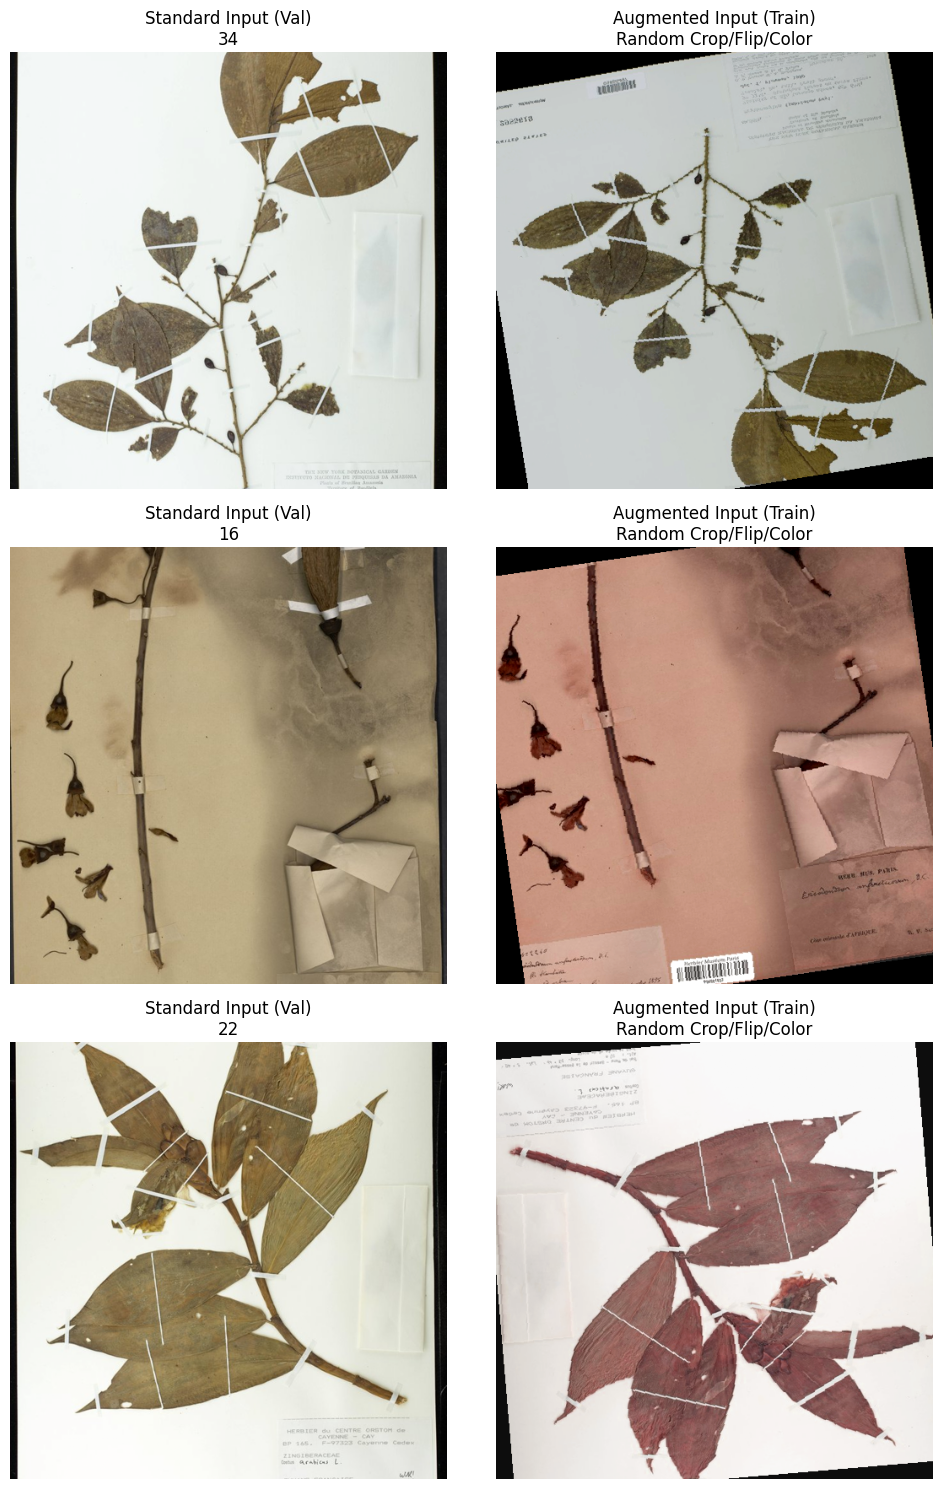

In [ ]:
# --- Helper to Un-Normalize images for visualization ---
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean=MEAN, std=STD)

def visualize_augmentation(df, data_dir, n_examples=3):
    fig, axs = plt.subplots(n_examples, 2, figsize=(10, 5 * n_examples))

    # Pick random samples
    samples = df.sample(n_examples)

    for i, (_, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(data_dir, row['filepath'])
        image = Image.open(img_path).convert("RGB")

        # Apply Valid Transform (What the model sees during testing)
        img_val = val_transform(image)
        img_val = unorm(img_val).permute(1, 2, 0).numpy() # Back to HWC for plot
        img_val = np.clip(img_val, 0, 1)

        # Apply Train Transform (What the model sees during training)
        img_train = train_transform(image)
        img_train = unorm(img_train).permute(1, 2, 0).numpy()
        img_train = np.clip(img_train, 0, 1)

        # Plot
        axs[i, 0].imshow(img_val)
        axs[i, 0].set_title(f"Standard Input (Val)\n{row['species_label']}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(img_train)
        axs[i, 1].set_title(f"Augmented Input (Train)\nRandom Crop/Flip/Color")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Run visualization
print("--- Visualizing Data Augmentations ---")
visualize_augmentation(df, DATA_DIR)

# **3.0 Model Definition (with LoRA)**
1.  **Load DINOv2:** We download the specific ViT-B/14 backbone.
2.  **Apply LoRA:** We inject low-rank adapters into the query, key, and value (`qkv`) matrices of the attention blocks. This allows the model to learn new patterns without retraining the entire network.
3.  **Custom Head:** We attach `MultiTaskClassifier` to predict Species (main task) and botanical attributes (auxiliary tasks).

## **3.1 Load the Base DINOv2 Mode**

In [ ]:
print("\n--- Loading Base DINOv2 Model ---")
path_to_model_files = kagglehub.model_download("juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default")
timm_model_name = 'vit_base_patch14_reg4_dinov2.lvd142m'
dinov2_base_model = timm.create_model(timm_model_name, pretrained=False)
dinov2_base_model.reset_classifier(0, '')
weights_filename = next((f for f in os.listdir(path_to_model_files) if f.endswith(('.pth', '.pt', '.tar'))), None)
weights_path = os.path.join(path_to_model_files, weights_filename)
checkpoint = torch.load(weights_path, map_location='cpu', weights_only=False)
state_dict = checkpoint.get('state_dict', checkpoint)
dinov2_base_model.load_state_dict(state_dict, strict=False)
print("✅ DINOv2 base model loaded successfully.")


--- Loading Base DINOv2 Model ---



100%|██████████| 9.79k/9.79k [00:00<00:00, 19.1MB/s]



  0%|          | 0.00/1.38G [00:00<?, ?B/s]



100%|██████████| 2.86k/2.86k [00:00<00:00, 5.82MB/s]

  0%|          | 1.00M/1.38G [00:00<13:43, 1.80MB/s]
  0%|          | 2.00M/1.38G [00:00<07:07, 3.46MB/s]
  0%|          | 5.00M/1.38G [00:00<02:45, 8.94MB/s]
  1%|          | 9.00M/1.38G [00:00<01:31, 16.1MB/s]
  1%|          | 12.0M/1.38G [00:01<01:18, 18.8MB/s]
  1%|          | 15.0M/1.38G [00:01<01:15, 19.5MB/s]
  1%|▏         | 18.0M/1.38G [00:01<01:15, 19.5MB/s]
  2%|▏         | 22.0M/1.38G [00:01<01:04, 22.8MB/s]
  2%|▏         | 25.0M/1.38G [00:01<00:58, 24.8MB/s]
  2%|▏         | 30.0M/1.38G [00:01<00:49, 29.2MB/s]
  2%|▏         | 35.0M/1.38G [00:01<00:54, 26.7MB/s]
  3%|▎         | 39.0M/1.38G [00:02<00:48, 29.7MB/s]
  3%|▎         | 43.0M/1.38G [00:02<00:51, 27.8MB/s]
  3%|▎         | 48.0M/1.38G [00:02<00:43, 32.9MB/s]
  4%|▎         | 52.0M/1.38G [00:02<00:42, 33.8MB/s]
  4%|▍         | 56.0M/1.38G [00:02<00:43, 32.8MB/s]
  4%|▍         | 61.0M/1.38G [00:02<00:38, 37.0MB/s]
  5%|▍         | 65.0M/1.38G [00:02<00:37, 

✅ DINOv2 base model loaded successfully.


## **3.2 Configure and Apply LoRA**

In [ ]:
print("\n--- Configuring and Applying LoRA ---")
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["qkv"],
    lora_dropout=0.1,
    bias="none",
)
dinov2_lora_model = get_peft_model(dinov2_base_model, lora_config)
print("✅ LoRA layers applied to DINOv2 model.")
dinov2_lora_model.print_trainable_parameters()


--- Configuring and Applying LoRA ---
✅ LoRA layers applied to DINOv2 model.
trainable params: 589,824 || all params: 87,171,840 || trainable%: 0.6766


## **3.3: Define the Multi-Task Classifier Head**

In [ ]:
class MultiTaskClassifier(nn.Module):
    def __init__(self, input_dim, num_species, num_shapes, num_arrs):
        super().__init__()
        self.shared_body = nn.Sequential(nn.Linear(input_dim, 512), nn.ReLU(), nn.Dropout(0.5))
        self.species_head = nn.Linear(512, num_species)
        self.shape_head = nn.Linear(512, num_shapes)
        self.arr_head = nn.Linear(512, num_arrs)
    def forward(self, x):
        shared_features = self.shared_body(x)
        species_output = self.species_head(shared_features)
        shape_output = self.shape_head(shared_features)
        arr_output = self.arr_head(shared_features)
        return species_output, shape_output, arr_output

print("\n✅ MultiTaskClassifier class defined.")


✅ MultiTaskClassifier class defined.


## **3.4: Create the Final End-to-End Model**

In [ ]:
class EndToEndLoRAModel(nn.Module):
    def __init__(self, feature_extractor, classifier):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.classifier = classifier

    def forward(self, x):
        features = self.feature_extractor(x)
        cls_feature = features[:, 0, :]
        return self.classifier(cls_feature)

print("✅ EndToEndLoRAModel class defined.")

✅ EndToEndLoRAModel class defined.


# **4.0 Model Training**
We define the hyperparameters and the **Weighted Loss Function**.
*   `ALPHA = 1.0` (Species Loss Priority)
*   `BETA = 0.3` (Shape/Arrangement Priority)

We also implement logic to **resume training** if a checkpoint exists (useful if Colab disconnects).

## **4.1 Set Hyperparameters and Initialize for Training**

In [ ]:
from sklearn.metrics import top_k_accuracy_score, accuracy_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# --- Hyperparameters ---
LEARNING_RATE = 1e-4
# NOTE: End-to-end training often requires fewer epochs to converge. Start with 10-20.
EPOCHS = 20
BATCH_SIZE = 16
ALPHA = 1.0
BETA_SHAPE = 0.3
BETA_ARR = 0.3

# --- Setup Image DataLoaders ---
train_dataset = MultiTaskImageDataset(train_df, DATA_DIR, train_transform)
val_dataset = MultiTaskImageDataset(val_df, DATA_DIR, val_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# --- Initialize the End-to-End Model ---
num_species = df_unordered['species_label'].nunique()
num_shapes = df_unordered['leaf_shape_label'].nunique()
num_arrs = df_unordered['leaf_arrangement_label'].nunique()
dino_output_dim = 768 # DINOv2 Base model output dimension

classifier_head = MultiTaskClassifier(
    input_dim=dino_output_dim,
    num_species=num_species,
    num_shapes=num_shapes,
    num_arrs=num_arrs
)
end_to_end_model = EndToEndLoRAModel(dinov2_lora_model, classifier_head).to(DEVICE)
optimizer = torch.optim.Adam(end_to_end_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# --- History tracking ---
history = { 'train_loss': [],
           'val_loss': [],
            'val_top1_acc': [],
            'val_top5_acc': [] }

print("\n✅ Setup complete. Ready for end-to-end LoRA training.")
print(f"Batch size set to {BATCH_SIZE}. If you get a CUDA out-of-memory error, reduce this further.")


# --- Checkpoint Configuration ---
CHECKPOINT_DIR = os.path.join(PROJECT_PATH, 'lora_checkpoints')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"\n✅ Checkpoints will be saved in: {CHECKPOINT_DIR}")


✅ Setup complete. Ready for end-to-end LoRA training.
Batch size set to 16. If you get a CUDA out-of-memory error, reduce this further.

✅ Checkpoints will be saved in: /content/drive/My Drive/Colab Notebooks/COS30082_ML_Project/lora_checkpoints


### **4.1.5 (Load Checkpoint Logic)**

In [ ]:
import json

# --- Variables to track training state ---
start_epoch = 0
history = { 'train_loss': [], 'val_loss': [], 'val_top1_acc': [], 'val_top5_acc': [] }

# --- Check for the latest checkpoint ---
latest_checkpoint_path = os.path.join(CHECKPOINT_DIR, 'latest_checkpoint.pth')

if os.path.exists(latest_checkpoint_path):
    print(f"--- Resuming training from checkpoint: {latest_checkpoint_path} ---")
    checkpoint = torch.load(latest_checkpoint_path, weights_only=False)

    # Load model and optimizer states
    end_to_end_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load training progress
    start_epoch = checkpoint['epoch'] + 1 # We start on the next epoch
    history = checkpoint['history']

    print(f"✅ Resuming from Epoch {start_epoch}. Model, optimizer, and history loaded.")
else:
    print("--- No checkpoint found. Starting training from scratch. ---")

--- Resuming training from checkpoint: /content/drive/My Drive/Colab Notebooks/COS30082_ML_Project/lora_checkpoints/latest_checkpoint.pth ---
✅ Resuming from Epoch 20. Model, optimizer, and history loaded.


## **4.2 Run the Training and Validation Loop**

In [ ]:
print("\n--- Starting/Resuming End-to-End LoRA Training ---")

# Use start_epoch to resume correctly from the last completed epoch
for epoch in tqdm(range(start_epoch, EPOCHS), desc="Training Progress"):

    # --- Training Logic ---
    end_to_end_model.train()
    total_train_loss = 0
    # Loop through the training data
    for images, s_labels, sh_labels, a_labels in train_loader:
        images, s_labels, sh_labels, a_labels = images.to(DEVICE), s_labels.to(DEVICE), sh_labels.to(DEVICE), a_labels.to(DEVICE)
        optimizer.zero_grad()
        s_preds, sh_preds, a_preds = end_to_end_model(images)
        loss_species = criterion(s_preds, s_labels)
        loss_shape = criterion(sh_preds, sh_labels)
        loss_arr = criterion(a_preds, a_labels)
        total_loss = (ALPHA * loss_species) + (BETA_SHAPE * loss_shape) + (BETA_ARR * loss_arr)
        total_loss.backward()
        optimizer.step()
        total_train_loss += total_loss.item()

    # --- Validation Logic ---
    end_to_end_model.eval()
    total_val_loss = 0
    val_preds_list, val_labels_list = [], []
    with torch.no_grad():
        # Loop through the validation data
        for images, s_labels, sh_labels, a_labels in val_loader:
            images, s_labels, sh_labels, a_labels = images.to(DEVICE), s_labels.to(DEVICE), sh_labels.to(DEVICE), a_labels.to(DEVICE)
            s_preds, sh_preds, a_preds = end_to_end_model(images)
            loss_species = criterion(s_preds, s_labels)
            loss_shape = criterion(sh_preds, sh_labels)
            loss_arr = criterion(a_preds, a_labels)
            total_val_loss += ((ALPHA * loss_species) + (BETA_SHAPE * loss_shape) + (BETA_ARR * loss_arr)).item()
            val_preds_list.append(s_preds.cpu())
            val_labels_list.append(s_labels.cpu())

    val_preds_all = torch.cat(val_preds_list)
    val_labels_all = torch.cat(val_labels_list)
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    val_top1_acc = accuracy_score(val_labels_all, val_preds_all.argmax(dim=1))
    val_top5_acc = top_k_accuracy_score(val_labels_all, val_preds_all, k=5)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_top1_acc'].append(val_top1_acc)
    history['val_top5_acc'].append(val_top5_acc)
    print(f"Epoch {epoch+1:02d}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Top-1 Acc: {val_top1_acc*100:.2f}%")


    # --- This is the checkpoint saving logic ---
    # The modulo operator (%) checks for a remainder.
    # (epoch + 1) % 5 == 0 is TRUE for epochs 5, 10, 15, etc.
    # We also explicitly save on the final epoch to ensure we always have the finished model.
    if (epoch + 1) % 5 == 0 or (epoch + 1) == EPOCHS:
        checkpoint_path = os.path.join(CHECKPOINT_DIR, 'latest_checkpoint.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': end_to_end_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
        }, checkpoint_path)

        epoch_checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': end_to_end_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
        }, epoch_checkpoint_path)
        print(f"✅ Checkpoint saved for epoch {epoch+1}")

print("\n✅ LoRA Training complete.")


--- Starting/Resuming End-to-End LoRA Training ---


Training Progress: 0it [00:00, ?it/s]


✅ LoRA Training complete.


## **4.3 Plot Training and Validation Graphs**

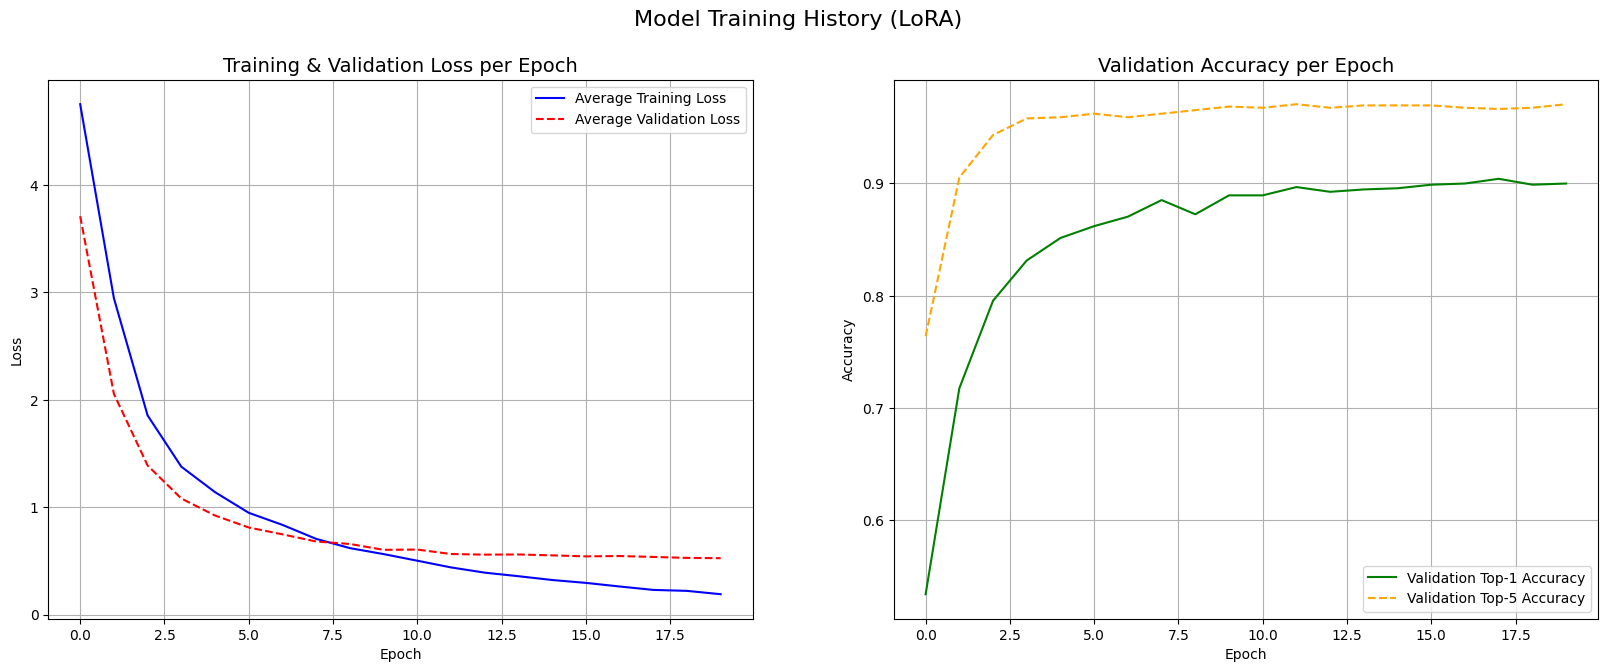

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1.plot(history['train_loss'], label='Average Training Loss', color='blue')
ax1.plot(history['val_loss'], label='Average Validation Loss', color='red', linestyle='--')
ax1.set_title('Training & Validation Loss per Epoch', fontsize=14)
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history['val_top1_acc'], label='Validation Top-1 Accuracy', color='green')
ax2.plot(history['val_top5_acc'], label='Validation Top-5 Accuracy', color='orange', linestyle='--')
ax2.set_title('Validation Accuracy per Epoch', fontsize=14)
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy'); ax2.legend(); ax2.grid(True)
plt.suptitle('Model Training History (LoRA)', fontsize=16)
plt.show()

## **4.4 Baseline Evaluation: LoRA Only (No Test-Time Adaptation)**

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from torch.utils.data import Dataset, DataLoader

print("--- Running Baseline Evaluation (LoRA Only) ---")

# --- 0. Define Test Dataset Class (Must be defined here!) ---
class TestImageDataset(Dataset):
    def __init__(self, filepaths, labels, data_dir, transform):
        self.filepaths = filepaths
        self.labels = labels
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.filepaths[idx])
        image = Image.open(img_path).convert("RGB")
        return self.transform(image), self.labels[idx]

# --- 1. Setup Test Data ---
test_list_path = os.path.join(DATA_DIR, 'list', 'test.txt')
groundtruth_path = os.path.join(DATA_DIR, 'list', 'groundtruth.txt')
no_pairs_path = os.path.join(DATA_DIR, 'list', 'class_without_pairs.txt')

# Load Labels and Masks
y_test_classids = pd.read_csv(groundtruth_path, sep=' ', header=None)[1].to_numpy()
classid_to_label = dict(zip(df_unordered['classid'], df_unordered['species_label']))
y_test_numpy = np.array([classid_to_label[cid] for cid in y_test_classids])

with open(no_pairs_path, 'r') as f:
    herbarium_only_classids = {int(line.strip()) for line in f}

# Load Loader
test_filepaths = pd.read_csv(test_list_path, sep=' ', header=None, names=['filepath', 'classid'])['filepath'].tolist()

# Use val_transform (Clean)
test_dataset = TestImageDataset(test_filepaths, y_test_numpy, DATA_DIR, val_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

--- Running Baseline Evaluation (LoRA Only) ---


In [ ]:
# --- 2. Run Inference ---
end_to_end_model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating Baseline"):
        images = images.to(DEVICE)

        # Standard Forward Pass
        s_preds, _, _ = end_to_end_model(images)
        probs = F.softmax(s_preds, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.numpy())

# --- 3. Calculate Metrics ---
final_probs = np.vstack(all_probs)
final_labels = np.concatenate(all_labels)
final_preds = np.argmax(final_probs, axis=1)
all_possible_labels = np.arange(num_species)

print("\n--- Baseline Results (LoRA Only) ---")

# Overall
acc1 = accuracy_score(final_labels, final_preds)
acc5 = top_k_accuracy_score(final_labels, final_probs, k=5, labels=all_possible_labels)
print(f"Overall Top-1: {acc1*100:.2f}%")
print(f"Overall Top-5: {acc5*100:.2f}%")

# Breakdown
is_herbarium_only_mask = np.isin(y_test_classids, list(herbarium_only_classids))
is_with_pairs_mask = ~is_herbarium_only_mask

if sum(is_with_pairs_mask) > 0:
    acc1_p = accuracy_score(final_labels[is_with_pairs_mask], final_preds[is_with_pairs_mask])
    acc5_p = top_k_accuracy_score(final_labels[is_with_pairs_mask], final_probs[is_with_pairs_mask], k=5, labels=all_possible_labels)
    print(f"\n[With-Pairs] Top-1: {acc1_p*100:.2f}% | Top-5: {acc5_p*100:.2f}%")

if sum(is_herbarium_only_mask) > 0:
    acc1_h = accuracy_score(final_labels[is_herbarium_only_mask], final_preds[is_herbarium_only_mask])
    acc5_h = top_k_accuracy_score(final_labels[is_herbarium_only_mask], final_probs[is_herbarium_only_mask], k=5, labels=all_possible_labels)
    print(f"[Herbarium-Only] Top-1: {acc1_h*100:.2f}% | Top-5: {acc5_h*100:.2f}%")

Evaluating Baseline:   0%|          | 0/13 [00:00<?, ?it/s]


--- Baseline Results (LoRA Only) ---
Overall Top-1: 79.71%
Overall Top-5: 89.86%

[With-Pairs] Top-1: 94.77% | Top-5: 98.69%
[Herbarium-Only] Top-1: 37.04% | Top-5: 64.81%


# **6.0 Final Evaluation: TenCrop TTA**
Single-image evaluation is prone to error if the leaf is blocked or the framing is bad. 
**TenCrop TTA** extracts 10 variations of the image (4 corners + center, and their flipped versions), predicts on all of them, and averages the results. This is the standard for high-accuracy competition submissions.

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

print("--- Running Evaluation: TenCrop TTA Only ---")

# --- 1. Define TTA Transforms (TenCrop) ---
# Resize slightly larger, then take 10 crops (4 corners + center, + flips)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

tta_transform = transforms.Compose([
    transforms.Resize(546, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.TenCrop(518),
    transforms.Lambda(lambda crops: torch.stack([
        transforms.Normalize(mean=MEAN, std=STD)(transforms.ToTensor()(crop))
        for crop in crops
    ]))
])

# --- 2. Define Dataset Class ---
class TestImageDataset(Dataset):
    def __init__(self, filepaths, labels, data_dir, transform):
        self.filepaths = filepaths
        self.labels = labels
        self.data_dir = data_dir
        self.transform = transform
    def __len__(self): return len(self.filepaths)
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.filepaths[idx])
        image = Image.open(img_path).convert("RGB")
        return self.transform(image), self.labels[idx]

# --- 3. Setup Data Loading ---
test_list_path = os.path.join(DATA_DIR, 'list', 'test.txt')
groundtruth_path = os.path.join(DATA_DIR, 'list', 'groundtruth.txt')
no_pairs_path = os.path.join(DATA_DIR, 'list', 'class_without_pairs.txt')

# Load Labels
y_test_classids = pd.read_csv(groundtruth_path, sep=' ', header=None)[1].to_numpy()
classid_to_label = dict(zip(df_unordered['classid'], df_unordered['species_label']))
y_test_numpy = np.array([classid_to_label[cid] for cid in y_test_classids])

# Load "Herbarium Only" Class IDs
with open(no_pairs_path, 'r') as f:
    herbarium_only_classids = {int(line.strip()) for line in f}

# Create Loader
test_filepaths = pd.read_csv(test_list_path, sep=' ', header=None, names=['filepath', 'classid'])['filepath'].tolist()
test_dataset = TestImageDataset(test_filepaths, y_test_numpy, DATA_DIR, tta_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)


--- Running Evaluation: TenCrop TTA Only ---


In [ ]:
# --- 4. Run Inference ---
end_to_end_model.eval()
all_probs = []
all_labels = []

num_species = df_unordered['species_label'].nunique()

with torch.no_grad():
    for images, label in tqdm(test_loader, desc="TTA Inference"):
        # images shape: [Batch=1, Crops=10, Channels=3, H=518, W=518]
        images = images.to(DEVICE)

        # Flatten to [10, 3, 518, 518] to feed into model as a batch
        bs, ncrops, c, h, w = images.size()
        model_input = images.view(-1, c, h, w)

        # Forward pass
        # We use the full model here to get logits directly
        # Note: We don't use get_embedding here because we want the Classifier output, not features
        s_preds, _, _ = end_to_end_model(model_input)

        # Get probabilities for all 10 crops
        probs = F.softmax(s_preds, dim=1) # [10, Num_Classes]

        # AVERAGE the probabilities across the 10 crops
        avg_prob = probs.mean(dim=0) # [Num_Classes]

        all_probs.append(avg_prob.cpu().numpy())
        all_labels.append(label.item())


TTA Inference:   0%|          | 0/207 [00:00<?, ?it/s]

In [ ]:
# --- 5. Metrics ---
final_probs = np.vstack(all_probs)
final_labels = np.array(all_labels)
final_preds = np.argmax(final_probs, axis=1)
all_possible_labels = np.arange(num_species)

print("\n--- Results: TenCrop TTA Only (No Adaptation) ---")

# Overall
top1 = accuracy_score(final_labels, final_preds)
top5 = top_k_accuracy_score(final_labels, final_probs, k=5, labels=all_possible_labels)
print(f"Overall Top-1: {top1*100:.2f}%")
print(f"Overall Top-5: {top5*100:.2f}%")

# Breakdown
is_herbarium_only_mask = np.isin(y_test_classids, list(herbarium_only_classids))
is_with_pairs_mask = ~is_herbarium_only_mask

if sum(is_with_pairs_mask) > 0:
    acc1 = accuracy_score(final_labels[is_with_pairs_mask], final_preds[is_with_pairs_mask])
    acc5 = top_k_accuracy_score(final_labels[is_with_pairs_mask], final_probs[is_with_pairs_mask], k=5, labels=all_possible_labels)
    print(f"\n[With-Pairs] Top-1: {acc1*100:.2f}% | Top-5: {acc5*100:.2f}%")

if sum(is_herbarium_only_mask) > 0:
    acc1 = accuracy_score(final_labels[is_herbarium_only_mask], final_preds[is_herbarium_only_mask])
    acc5 = top_k_accuracy_score(final_labels[is_herbarium_only_mask], final_probs[is_herbarium_only_mask], k=5, labels=all_possible_labels)
    print(f"[Herbarium-Only] Top-1: {acc1*100:.2f}% | Top-5: {acc5*100:.2f}%")


--- Results: TenCrop TTA Only (No Adaptation) ---
Overall Top-1: 80.68%
Overall Top-5: 89.37%

[With-Pairs] Top-1: 94.77% | Top-5: 98.69%
[Herbarium-Only] Top-1: 40.74% | Top-5: 62.96%


# **7.0 Save the Trained Model**
Because we used PEFT/LoRA, we save the **adapters** and the **classifier head** separately. This keeps the file size small.

In [ ]:
print("\n--- Saving LoRA Adapters and Classifier Head ---")
# Define save paths
LORA_SAVE_PATH = os.path.join(PROJECT_PATH, 'pipeline2_lora_adapters')
CLASSIFIER_SAVE_PATH = os.path.join(PROJECT_PATH, 'pipeline2_lora_classifier.pth')

# Save the LoRA adapters
end_to_end_model.feature_extractor.save_pretrained(LORA_SAVE_PATH)

# Save the state dictionary of the classifier head
torch.save(end_to_end_model.classifier.state_dict(), CLASSIFIER_SAVE_PATH)

print(f"\n✅ LoRA adapters saved to: {LORA_SAVE_PATH}")
print(f"✅ Classifier head saved to: {CLASSIFIER_SAVE_PATH}")


--- Saving LoRA Adapters and Classifier Head ---

✅ LoRA adapters saved to: /content/drive/My Drive/Colab Notebooks/COS30082_ML_Project/pipeline2_lora_adapters
✅ Classifier head saved to: /content/drive/My Drive/Colab Notebooks/COS30082_ML_Project/pipeline2_lora_classifier.pth


# **8.0: Visualizing Predictions on the Test Set**
This section picks a random image from the test set, classifies it using the trained model, and retrieves a "Prototype" image (a herbarium sheet of the predicted species) from the training set to visually verify the match.

## **8.1: Prepare Data and Mappings for Visualization**

In [ ]:
print("\n--- Step 1: Preparing data for visualization ---")
label_to_name = dict(zip(df_unordered['species_label'], df_unordered['species_name']))
label_to_classid = dict(zip(df_unordered['species_label'], df_unordered['classid']))
classid_to_name = dict(zip(df_unordered['classid'], df_unordered['species_name']))
indices_with_pairs = np.where(is_with_pairs_mask)[0]
indices_herbarium_only = np.where(is_herbarium_only_mask)[0]
print("✅ Preparation complete.")


--- Step 1: Preparing data for visualization ---
✅ Preparation complete.


## **8.2: Define Helper and Visualization Functions**

In [ ]:
def find_example_training_image(class_id, train_df, data_dir):
    candidate_rows = train_df[train_df['classid'] == class_id]
    if candidate_rows.empty: return None
    candidate_paths = candidate_rows['filepath'].tolist()
    herbarium_paths = [p for p in candidate_paths if 'herbarium' in p]
    return os.path.join(data_dir, random.choice(herbarium_paths if herbarium_paths else candidate_paths))

def visualize_single_prediction(test_image_path, true_classid, top5_pred_labels, top5_probs, train_df, data_dir):
    true_name = f"'{classid_to_name.get(true_classid, 'Unknown')}' (ID: {true_classid})"
    top1_pred_label = top5_pred_labels[0]
    top1_pred_classid = label_to_classid.get(top1_pred_label, -1)
    is_correct = (top1_pred_classid == true_classid)
    top5_names = [f"'{label_to_name.get(p_label, 'N/A')}' (ID: {label_to_classid.get(p_label, 'N/A')})" for p_label in top5_pred_labels]
    test_image = Image.open(test_image_path)
    predicted_example_path = find_example_training_image(top1_pred_classid, train_df, data_dir)
    predicted_example_image = Image.open(predicted_example_path) if predicted_example_path else Image.new('RGB', (518, 518), 'lightgray')
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].imshow(test_image); axs[0].set_title("Test Image"); axs[0].axis('off')
    axs[1].imshow(predicted_example_image); axs[1].set_title(f"Model's Top Guess:\n{top5_names[0]}"); axs[1].axis('off')
    fig.suptitle(f"Prediction for Image: {os.path.basename(test_image_path)}\n"
                 f"Actual Species: {true_name}\n"
                 f"Result: {'✅ CORRECT' if is_correct else '❌ INCORRECT'}",
                 fontsize=16, color='green' if is_correct else 'red')
    text_lines = ["Top 5 Predictions:", "="*20] + [f"{i+1}: {name}\n    (Confidence: {prob:.2%})" for i, (name, prob) in enumerate(zip(top5_names, top5_probs))]
    plt.figtext(0.92, 0.5, "\n".join(text_lines), fontsize=12, va="center", ha="left")
    plt.tight_layout(rect=[0, 0, 0.85, 0.9])
    plt.show()

## **8.3: Run and Visualize Predictions**


--- Step 2: Visualizing Previously Computed Adaptation Results ---

   Analyzing 2 random 'With-Pairs' samples

Visualizing 'With-Pairs' image 103: 2218.jpg


/tmp/ipython-input-3792979133.py:26: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 0.85, 0.9])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


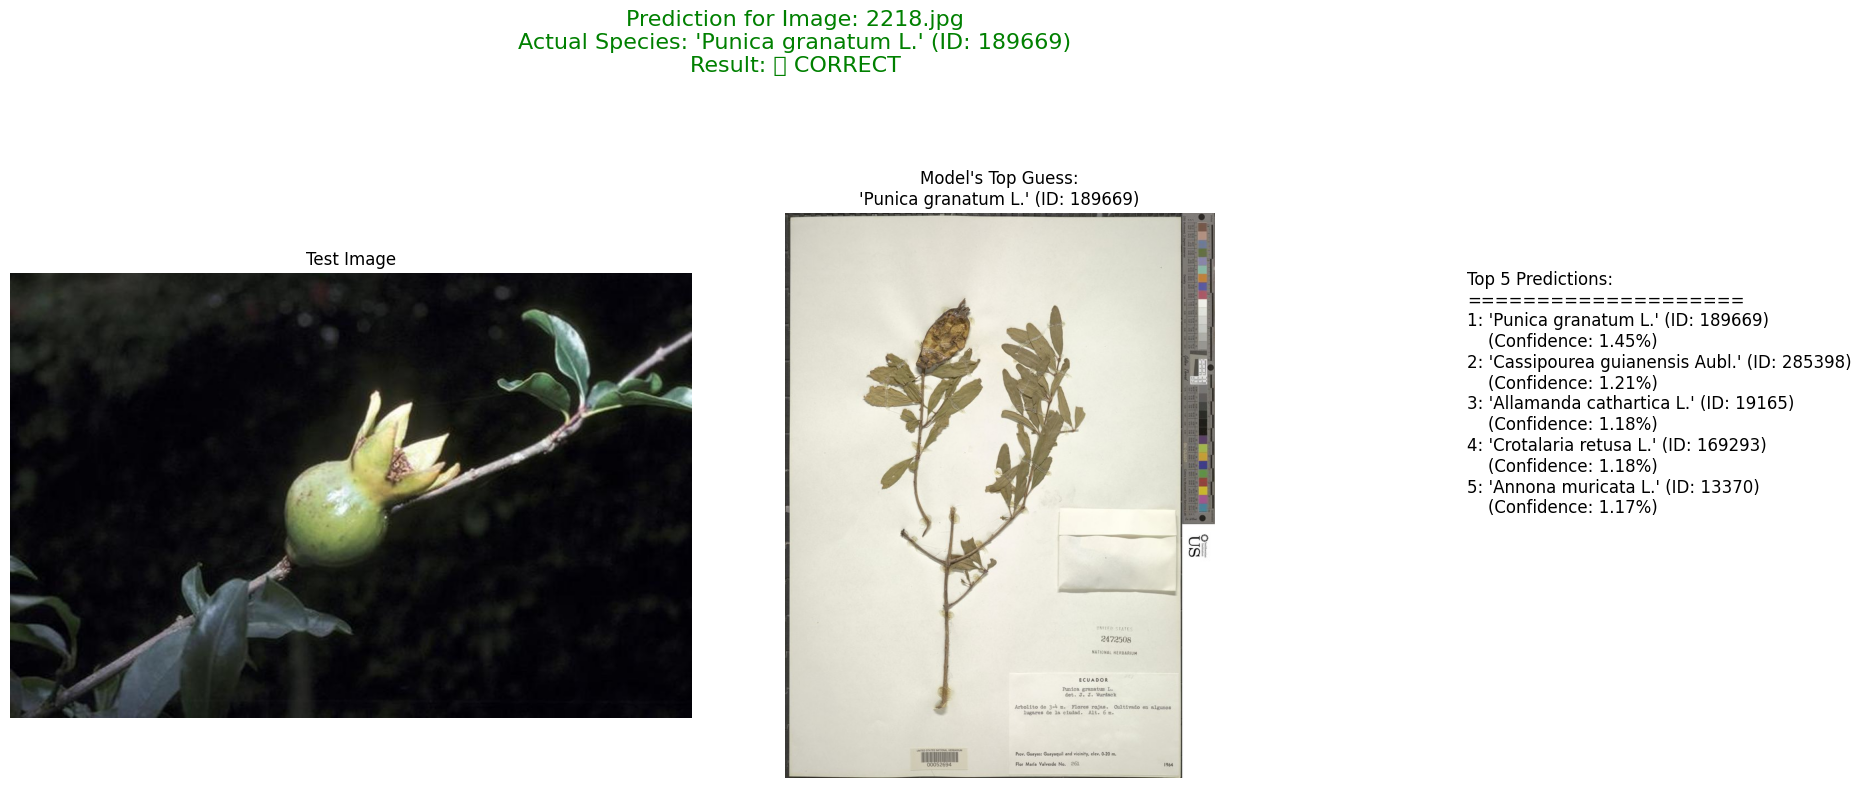


Visualizing 'With-Pairs' image 145: 26425.jpg


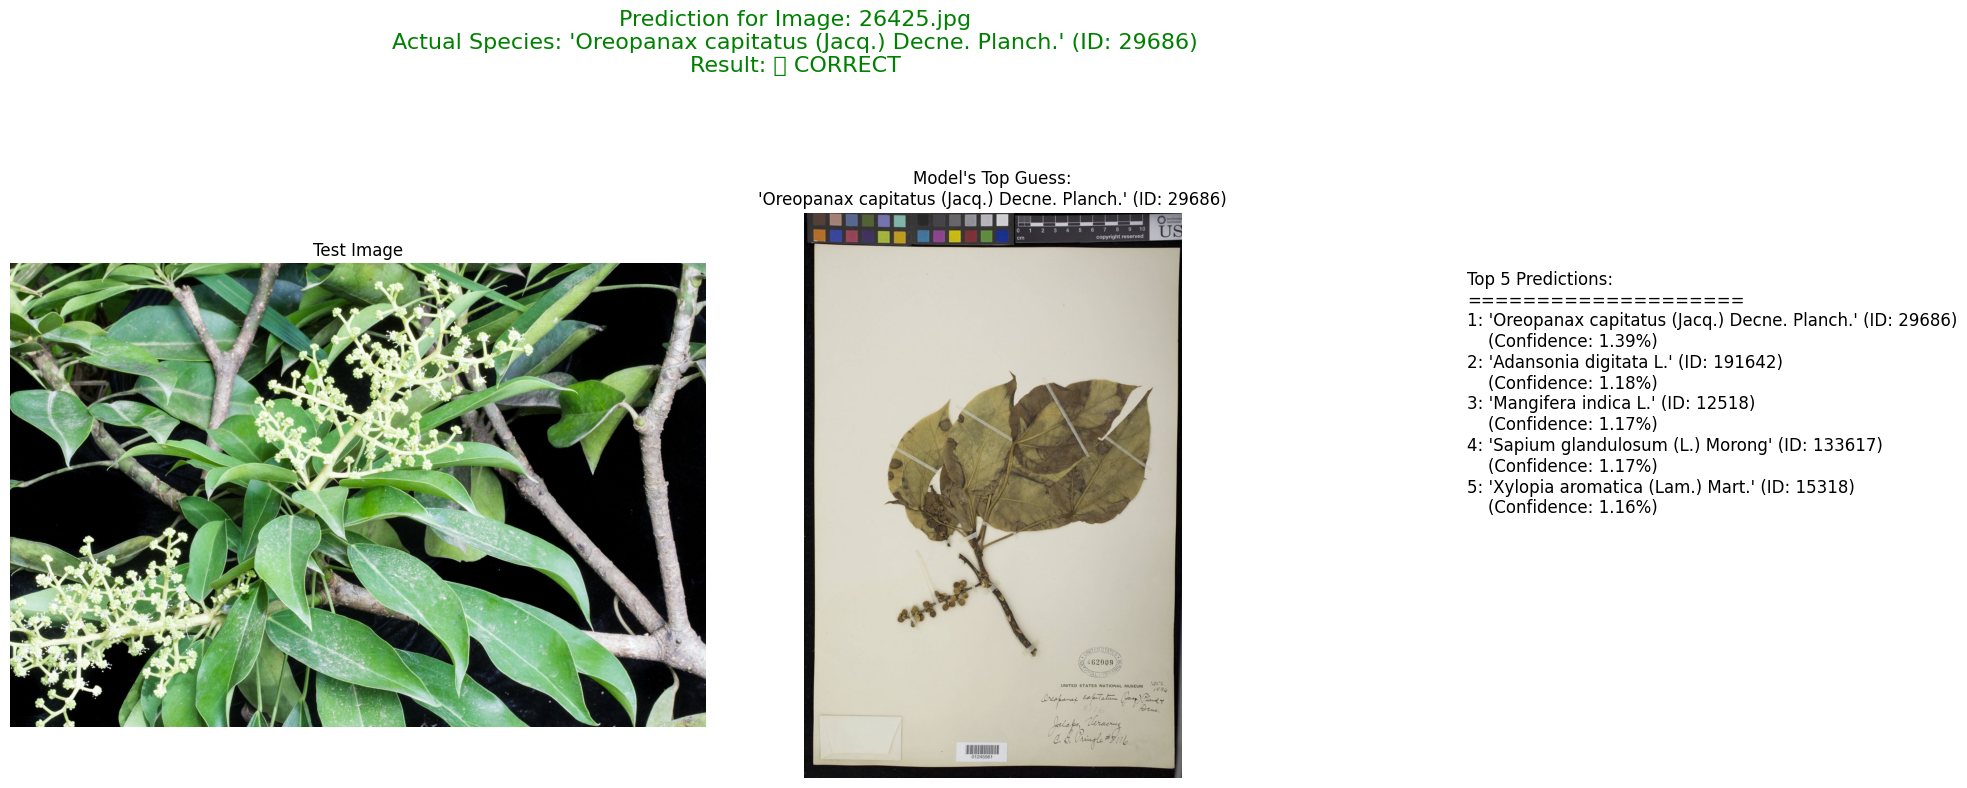


   Analyzing 2 random 'Herbarium-Only' samples

Visualizing 'Herbarium-Only' image 4: 284716.jpg


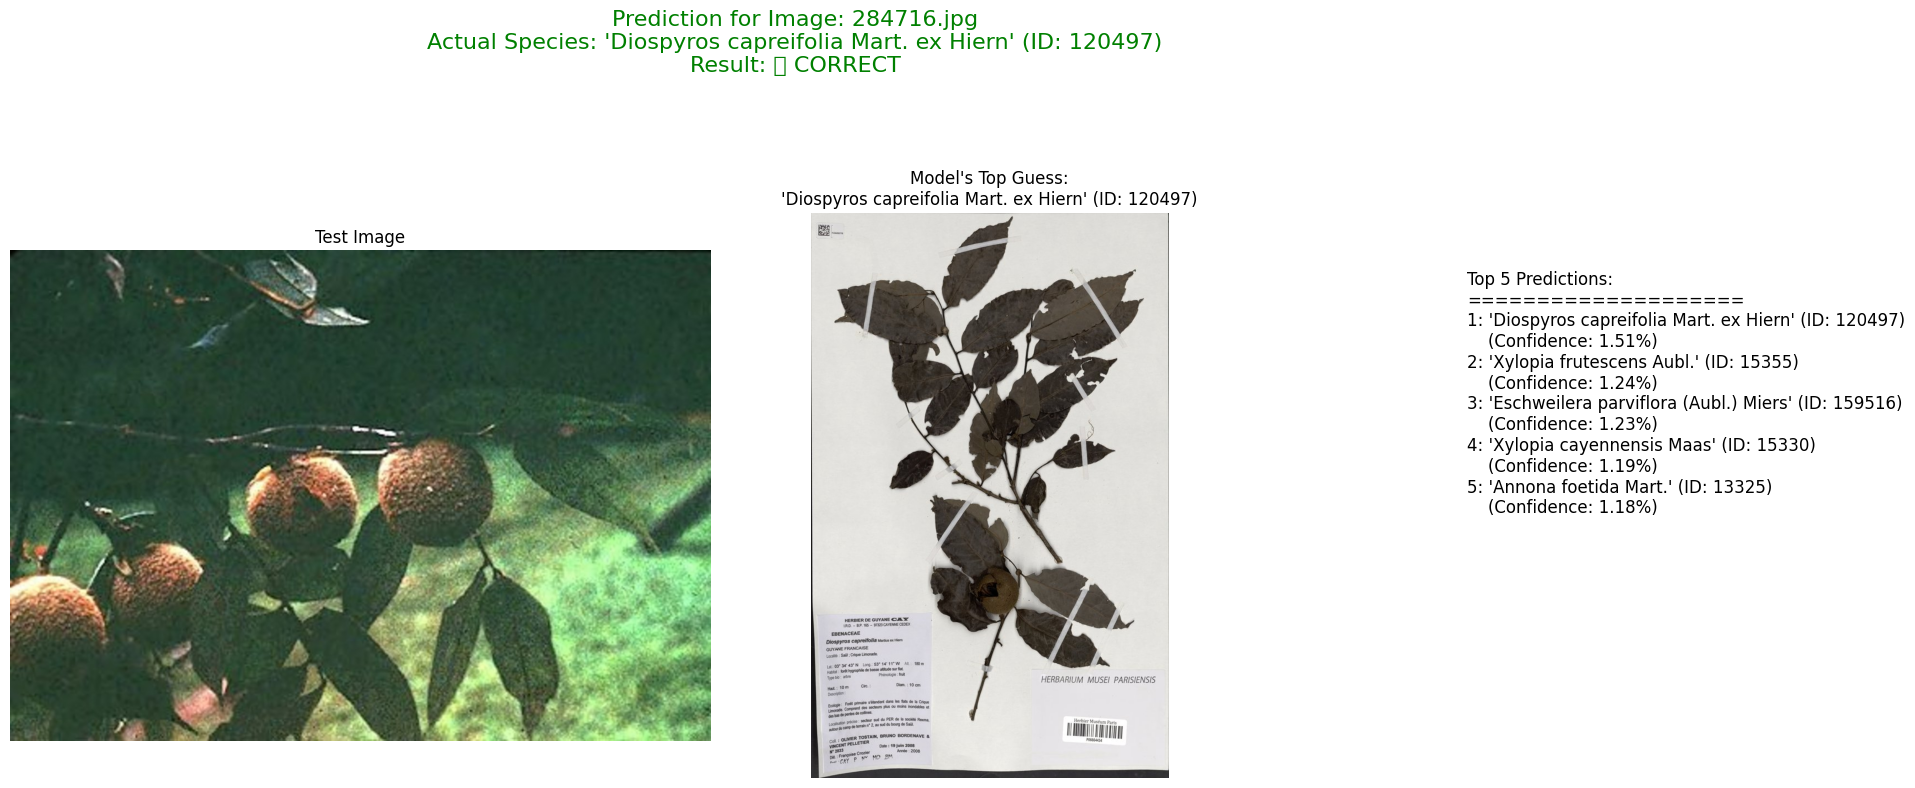


Visualizing 'Herbarium-Only' image 27: 252016.jpg


/tmp/ipython-input-3792979133.py:26: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 0.85, 0.9])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


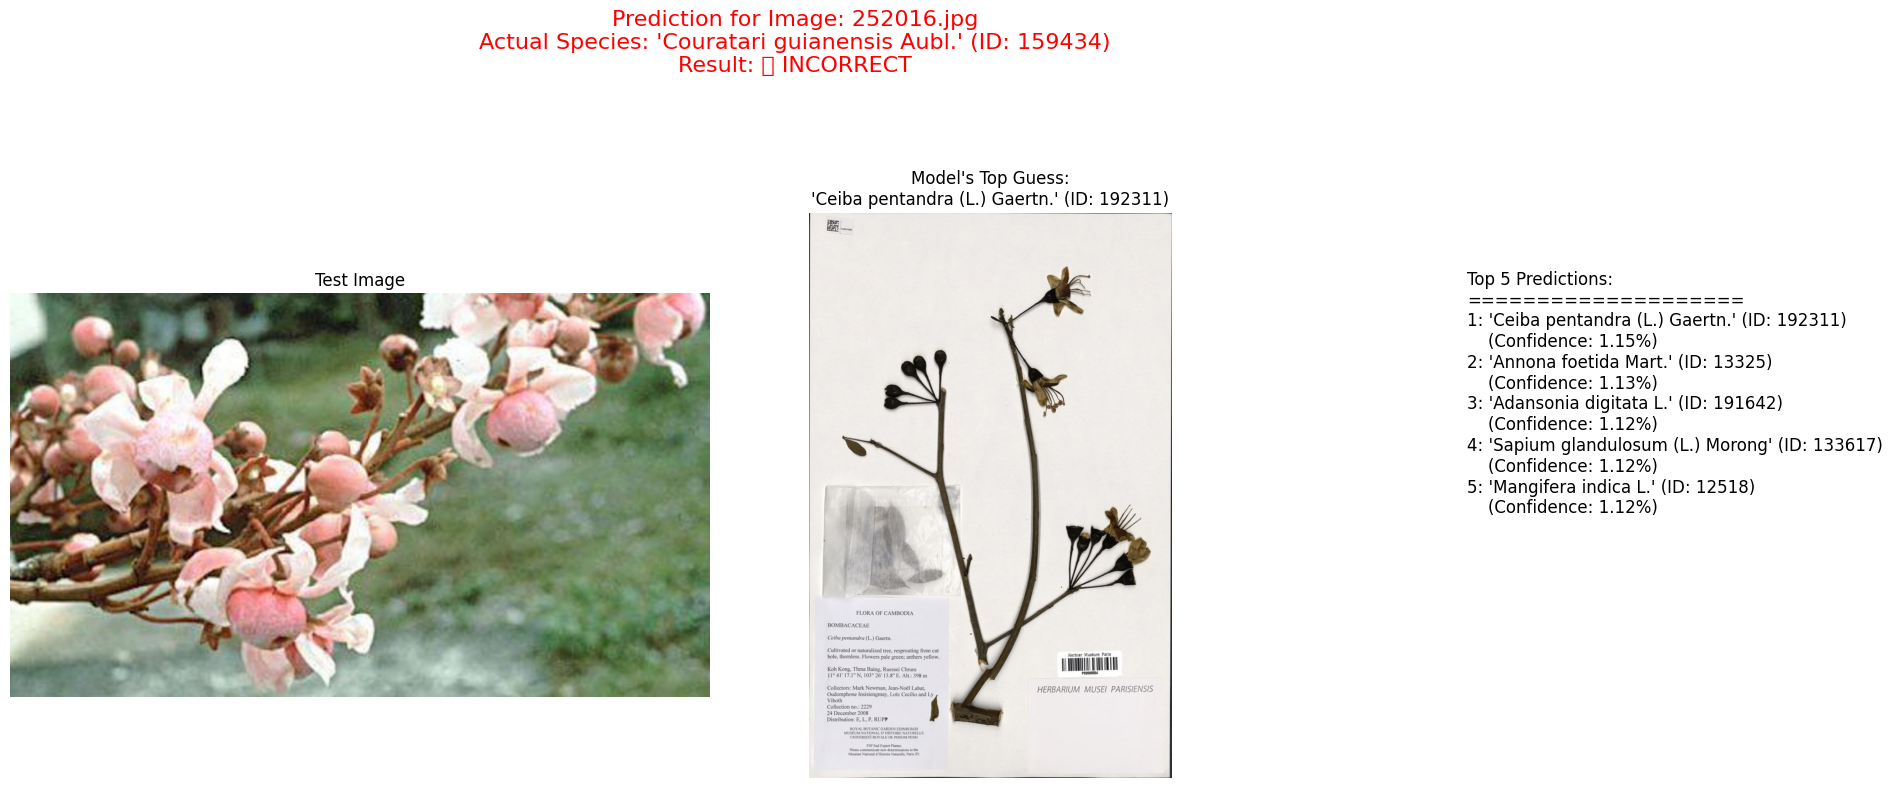

In [ ]:
print("\n--- Step 2: Visualizing Previously Computed Adaptation Results ---")
# The variable 'final_probs_all' was computed in Section 5.2 and holds all
# the adapted prediction probabilities for the entire test set.

# --- Visualize 'With-Pairs' samples ---
print("\n" + "="*50 + "\n   Analyzing 2 random 'With-Pairs' samples\n" + "="*50)
if len(indices_with_pairs) > 0:
    for idx in random.sample(list(indices_with_pairs), min(2, len(indices_with_pairs))):
        image_path = os.path.join(DATA_DIR, test_filepaths[idx])
        print(f"\nVisualizing 'With-Pairs' image {idx}: {os.path.basename(image_path)}")

        # 1. Get the adapted probabilities for this image from our saved results.
        adapted_probabilities = final_probs_all[idx]
        # 2. Find the top 5 predictions from these adapted probabilities.
        top5_pred_indices = np.argsort(adapted_probabilities)[-5:][::-1]

        # 3. Call the visualization function with the ADAPTED results.
        visualize_single_prediction(
            image_path,
            y_test_classids[idx],
            top5_pred_indices,
            adapted_probabilities[top5_pred_indices], # Pass the corresponding probabilities
            df,
            DATA_DIR
        )

# --- Visualize 'Herbarium-Only' samples ---
print("\n" + "="*50 + "\n   Analyzing 2 random 'Herbarium-Only' samples\n" + "="*50)
if len(indices_herbarium_only) > 0:
    for idx in random.sample(list(indices_herbarium_only), min(2, len(indices_herbarium_only))):
        image_path = os.path.join(DATA_DIR, test_filepaths[idx])
        print(f"\nVisualizing 'Herbarium-Only' image {idx}: {os.path.basename(image_path)}")

        adapted_probabilities = final_probs_all[idx]
        top5_pred_indices = np.argsort(adapted_probabilities)[-5:][::-1]

        visualize_single_prediction(
            image_path,
            y_test_classids[idx],
            top5_pred_indices,
            adapted_probabilities[top5_pred_indices],
            df,
            DATA_DIR
        )